# 基本思路

使用word2vec技术，在词汇空间标注技能。然后用k-means方法，将技能聚类成固定的n个，用以表示一个人的技能。
然后用神经网络，根据n个技能标记，预测一个人的收入

word2vec库：[GloVe](https://github.com/stanfordnlp/GloVe)

# 代码流程

**第一次运行：**

1. 先运行`导入数据`中`导入技能、收入数据`的代码，导入原始技能、收入数据
2. 然后依次运行`Load Word Vectors`中的代码，最终得到所有词的词向量`skill_vecs.csv`

**构造训练数据**

运行「构造训练数据」中的代码，将训练数据存为`./data/train_data.csv`

**训练**
1. 导入`./data/train_data.csv`（参见`构造训练数据 - # 导入训练数据`），将数据存入skill_shapes和incomes中。
2. 运行NN中的一系列代码

# Import

In [1]:
import pandas as pd
import re
import csv
import numpy as np
import sklearn as skl
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as dataset
import torch.optim as optim
import seaborn as sb

# 导入数据

In [2]:
# 导入技能词的词向量
skill_vecs = pd.read_csv('./data/skill_vecs.csv', index_col=0)
vecs = skill_vecs.to_dict(orient='list')

In [3]:
# 导入技能、收入数据
skillJobData = pd.read_pickle('./data/kate_data/PNAS_workerdataframe_v4.pkl')

# 技能画像

In [4]:
# 获取所有技能的词向量
def get_skill_vec(skills):
    skill_vecs = []
    for skill in skills:
        #分别处理各个技能
        for word in re.split('-|/', skill):
            # 将技能词组拆分为单词
            if word in vecs:
                skill_vecs += [vecs[word]]
    return skill_vecs

In [8]:
# 一个人的技能画像
def skill_portrait(skills):
    # 获取此人的所有技能词向量
    s_vecs = get_skill_vec(skills)
    
    # 特殊情形处理
    if len(s_vecs) == 0:
        # 若没有数据，返回两个0向量
        return np.array([[0.] * 25, [0.] * 25])
    if len(s_vecs) == 1:
        # 若只有一个向量，返回两个相同的向量
        return np.array([s_vecs[0], s_vecs[0]])
    if len(s_vecs) == 2:
        # 若只有两个向量，直接返回这两个向量
        return np.array(s_vecs)
    
    # 确保词向量不是完全相同的
    t = True
    for i in range(len(s_vecs) - 1):
        t = t & (s_vecs[i] == s_vecs[i+1])
    if t:
        # 若全都相同，则返回前两个向量
        return np.array(s_vecs[:2])
    
    #用K-Means方法将词向量分为两簇
    kmeans = KMeans(n_clusters=2).fit(s_vecs)
    
    # 返回两簇的中心
    return np.array(kmeans.cluster_centers_)

测试：

In [9]:
print('skill:', skillJobData.skills[400])
skill_portrait(skillJobData.skills[400])

skill: ['data-entry']


array([[ 1.1666  ,  0.35531 , -0.29362 , -0.52206 ,  1.4224  , -0.30116 ,
         0.045792, -0.028705,  1.8792  ,  0.28175 ,  0.55703 , -0.71944 ,
        -3.0101  ,  0.41258 ,  0.3052  , -0.12702 , -0.25783 ,  0.90687 ,
        -0.026371, -1.0942  , -1.03    , -1.2379  , -0.65783 ,  0.14663 ,
        -1.3532  ],
       [-0.2789  ,  1.0225  , -0.18295 , -0.76763 ,  0.79161 , -1.0646  ,
         0.40288 , -0.85806 ,  0.72177 , -0.23864 ,  0.57031 ,  0.2479  ,
        -2.6287  ,  0.74601 ,  0.053133, -0.11872 ,  0.62547 , -0.44052 ,
        -0.81874 , -0.12305 , -1.1949  , -1.7244  ,  0.059832,  0.18729 ,
        -0.6976  ]])

### 构造训练数据

In [12]:
# 所有人的技能画像
skill_shapes = list(map(skill_portrait, skillJobData.skills))
# 所有人收入
incomes = skillJobData.log_realized_wage

In [15]:
# 确保数据长度相同
print(len(skill_shapes),len(incomes))

18283 18283


In [21]:
si_data = pd.DataFrame({'skill_shapes':skill_shapes, 'incomes':incomes}).dropna() # 删除NaN
skill_shapes = list(si_data.skill_shapes) # 获取清理后的技能画像
incomes = list(si_data.incomes) # 获取清理后的收入

# 存储数据
train_database = pd.DataFrame(([list(np.append(ss.flatten(), ic)) for ss,ic in zip(skill_shapes, incomes)]))
train_database.to_csv('./data/train_data.csv')

In [42]:
# 导入训练数据
train_database = pd.read_csv('./data/train_data.csv')
skill_shapes = np.array(train_database).T[1:-1].T
incomes = np.array(train_database).T[-1]

### 原始数据

In [4]:
skillJobData[1:5]

,city,country,description,feedbacks,hourly_rate,hours_worked,jobs_worked,last_active,portfolio,private,...,log_requested_wage,log_realized_wage,cp_num_USwork_groups_morethan1,cp_num_nonUSwork_groups_morethan1,cp_num_USwork_groups_trunc,cp_num_nonUSwork_groups_trunc,cp_num_USwork_groups_trunc3,cp_num_nonUSwork_groups_trunc3,cp_single_USgroup,cp_single_nonUSgroup
~010004a03173568fbf,Mykolaiv,Ukraine,"Hey! \n\nI am Dmitry, and I am experienced dev...",2.0,26.00,974.000000,2.0,Apr 09 86,0.0,False,...,3.258097,2.498563,2,2,2,3,2,3,NaN,NaN
~01000625aff3ab5e04,Kharkiv,Ukraine,I'm a lead of a small mobile team of skilled d...,2.0,24.00,100.000000,2.0,Aug 13 94,0.0,False,...,3.178054,3.178054,1,1,1,1,1,1,1.0,2.0
~010006ca29e70cb78d,Durand,United States,.,19.0,13.33,18.833333,22.0,Apr 29 10,0.0,False,...,2.590017,2.407846,2,1,2,1,2,1,NaN,0.0
~01000740f61cb7d11d,Savona,Italy,"Hi, my name is Vito Potenza and I am a freelan...",3.0,11.11,0.000000,3.0,Aug 09 72,0.0,False,...,2.407846,NaN,2,2,2,3,2,3,NaN,NaN


In [60]:
len(all_skill_keys.keys())

2091

# NN

In [43]:
class JobNet(nn.Module):
    def __init__(self):
        super(JobNet, self).__init__()
        self.fcn1 = nn.Linear(50, 25)
        self.fcn2 = nn.Linear(25, 10)
        self.fcn3 = nn.Linear(10, 1)
    def forward(self, x):
        # 三层fcn网络
        x = F.relu(self.fcn1(x))
        x = F.relu(self.fcn2(x))
        x = F.relu(self.fcn3(x))
        
        return x

# 训练数据
class JobData(dataset.Dataset):
    def __init__(self, skillvecs, income):
        super(JobData, self).__init__()
        self.skillvecs = torch.Tensor(list(map(lambda x:list(x.flatten()), skillvecs)))
        self.income = torch.Tensor(income).reshape(len(income),1)
        self.length = len(skillvecs)
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        return self.skillvecs[index], self.income[index]
    def cuda(self):
        self.income = self.income.cuda()
        self.skillvecs = self.skillvecs.cuda()

In [51]:
# 网络、数据
testNet = JobNet()
testData = JobData(skill_shapes[:5000], incomes[:5000])
testData.cuda()

dataloader = dataset.DataLoader(testData, batch_size=50, shuffle=True)

testNet.cuda()

loss_fn = torch.nn.MSELoss()
loss_fn.cuda()

optimizer = optim.SGD(testNet.parameters(), lr = 2e-5, momentum=0.9, weight_decay=0.000002)
#optimizer = optim.SGD(testNet.parameters(), lr = 1e-12)

epco_loss = 0
acc_count = 0

# 训练
for epco in range(10000):
    for inputdata, target in dataloader:
        optimizer.zero_grad()

        output = testNet.forward(inputdata)

        loss = loss_fn(output, target)
        epco_loss = epco_loss + loss

        loss.backward()
        optimizer.step()
    if (epco + 1) % 1000 == 0:
        print('epco', (epco + 1), 'loss:', epco_loss.item() / (500 * len(dataloader)))
        epco_loss = 0

epco 1000 loss: 1.38831515625
epco 2000 loss: 1.1804321875
epco 3000 loss: 1.138304296875
epco 4000 loss: 1.093123203125
epco 5000 loss: 1.049624765625
epco 6000 loss: 1.00995
epco 7000 loss: 0.97700484375
epco 8000 loss: 0.94711
epco 9000 loss: 0.9238228125
epco 10000 loss: 0.9048515625


## 分析

### 原始收入分布

/home/yanbo/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


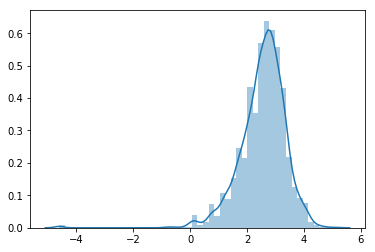

In [46]:
sb.distplot(testData.income.cpu())

### 比较真实收入-预测收入

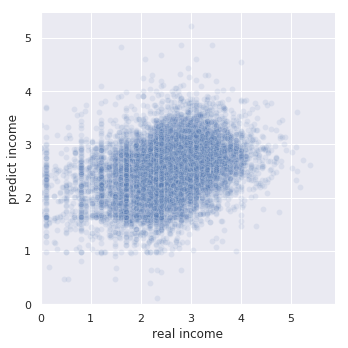

In [66]:
sb.set()

predict = [testNet.forward(torch.Tensor(sks.flatten()).cuda()).item() for sks in skill_shapes[5000:]]
real = [inc for inc in incomes[5000:]]

g = sb.relplot(x='real income', y='predict income', data=pd.DataFrame({'predict income':predict, 'real income':real}), alpha=0.1)
g.set(ylim=(0, None), xlim=(0, None))

### 预测收入分布

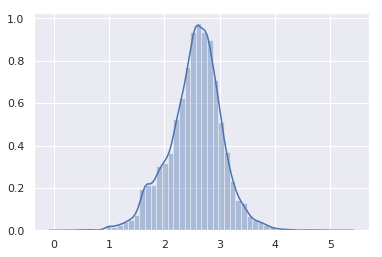

In [62]:
sb.distplot(predict)

### 预测准确度

In [65]:
income_s = np.median(real)

n = 0
t = 0

# 以中位数收入为标准，确定高低收入
# 测试其预测准确度
for p,r in zip(predict, real):
    n += 1
    if ((r > income_s) & (p > income_s)) | ((r < income_s) & (p < income_s)):
        t += 1

print('acc=',t/n)

acc= 0.6149966122110969


# Load Word Vectors

In [105]:
# 导入词向量
wvec_head = ['word'] + list(range(25)) # 表头
#vec_data=pd.read_csv('./data/word_vec/glove.twitter.27B.25d.txt', sep=' ', index_col=0, header=None, names=wvec_head, nrows=10)
# 导入数据
vec_data=pd.read_csv('./data/word_vec/glove.twitter.27B.25d.txt', sep=' ', index_col=0, header=None, names=wvec_head, error_bad_lines=False, quoting=csv.QUOTE_NONE)
print(len(vec_data))

1193514


In [106]:
indexs = vec_data.index # index即为词
word_dic=dict([[word, loc] for word,loc in zip(indexs, range(len(indexs)))]) # 构造查询词典

In [108]:
# 数据库大小
len(word_dic)

1193513

## 筛选词向量

In [59]:
# 所有技能
all_skills = skillJobData.skills

all_skill_keys = {}

# 获取不重复的、所有技能的词汇表
for skill_list in all_skills:
    for skill in skill_list:
        for skill_word in re.split('-|/', skill):
            if skill_word in all_skill_keys:
                all_skill_keys[skill_word] += 1
            else:
                all_skill_keys[skill_word] = 1
            

In [114]:
# 将找到的词存储下来
# 若词有对应的词向量，则存在vecs中
# 若没有，则存入unfound_words中，准备进一步处理

vecs = {}
unfound_words = {}

for word in all_skill_keys.keys():
    if word in word_dic:
        vecs[word] = list(vec_data.iloc[word_dic[word]])
    else:
        unfound_words[word] = all_skill_keys[word]

In [139]:
len(vecs)

1721

In [112]:
len(unfound_words)

370

In [138]:
# 准备处理常见的无词向量的词
unfound_words_list = list(zip(unfound_words.keys(),unfound_words.values()))
unfound_words_list.sort(key=(lambda x:x[1]), reverse=True)
dict(unfound_words_list[:13])

{'3d': 1692,
 'c#': 1574,
 'html5': 1509,
 'css3': 1202,
 '.net': 944,
 '2d': 325,
 'j2ee': 314,
 '3': 201,
 'ec2': 119,
 'win32': 119,
 'extjs': 107,
 'quarkxpress': 106,
 '4d': 102}

In [141]:
# 手动设定特殊词汇的词向量
vecs['c#'] = vecs['c']
vecs['html5'] = vecs['html']
vecs['css3'] = vecs['css']
vecs['win32'] = vecs['windows']

In [145]:
# 存储词向量数据
skill_vecs = pd.DataFrame(vecs)
skill_vecs.to_csv('./data/skill_vecs.csv')